In [207]:
# save files
fullproc_r = './resources/' # for words/names

# where to save the figures that are created
#fake_figs_dir = './example_hists/' # saving in github only for small numbers
# stop overwriting what is there
fake_figs_dir = '~/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/' # large dataset, same format
#fake_figs_dir = '~/LLM_VQA_JCDL2025/example_hists/fewshot/' # for fewshot learning


# format for saving images?
#img_format = ['pdf','jpeg']
img_format = ['jpeg']

# save diagnostic plot with all items labeled?
save_diagnostic_plot = True

# randomize names?
randomize_names = True

In [208]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import pickle
import pandas as pd
#import string
from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import ImageColor
import json
import os
from copy import deepcopy
import copy

from utils.metric_utils.utilities import isRectangleOverlap

import time

import matplotlib as mpl
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}' #for \text command

# written libs -- will update locally
from utils.synthetic_fig_utils import subset_by_percent, \
 get_nrows_and_ncols, normalize_params_prob, get_ticks, get_titles_or_labels, \
 get_font_info

from utils.plot_utils import get_contour_plot, get_histogram_plot, \
   get_line_plot, get_scatter_plot, make_plot, colorbar_mods#, get_line_plot

from utils.text_utils import get_popular_nouns, get_inline_math

# create a bunch of fake figures
from utils.synthetic_fig_utils import normalize_params_prob
from utils.plot_parameters import plot_types_params, panel_params, \
  title_params, xlabel_params, colorbar_params, \
  ylabel_params, aspect_fig_params, dpi_params, tight_layout_params, \
  fontsizes, base

from utils.data_utils import get_data, NumpyEncoder
import numpy as np

import utils.distribution_utils

from importlib import reload
from utils.plot_qa_utils import log_scale_ax
import utils.distribution_utils
import utils.data_utils
reload(utils.distribution_utils)
reload(utils.data_utils)
from utils.data_utils import get_data
import utils.plot_classes_utils
reload(utils.plot_classes_utils)

from utils.synthetic_fig_utils import add_titles_and_labels

import utils.plot_utils
import utils.data_utils
import utils.plot_classes_utils
reload(utils.plot_classes_utils)
reload(utils.data_utils)
reload(utils.plot_utils)
from utils.plot_utils import make_plot, make_base_plot
from utils.data_utils import get_data

from utils.plot_utils import markers, make_base_plot

import utils.synthetic_fig_utils
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import collect_plot_data_axes

marker_sizes = np.arange(0,10)+1
line_list_thick = np.arange(1,10)

use_uniques = True # use unique inlines
verbose = True

from sys import path
path.append('/Library/TeX/texbin/')

# debug
from importlib import reload

# for seed
from sys import maxsize as maxint

import warnings
warnings.filterwarnings("error")

In [209]:
# for some versions
fake_figs_dir = os.path.expanduser(fake_figs_dir)
#fake_figs_dir

In [210]:
# check directories
img_dir = fake_figs_dir + '/imgs/'
if not os.path.exists(img_dir):
    os.mkdir(img_dir)
    print('made:', img_dir)
json_dir = fake_figs_dir + '/jsons/'
if not os.path.exists(json_dir):
    os.mkdir(json_dir)
    print('made:', json_dir)

In [211]:
# get fonts -- see "cnn_create_synthetic_ticks" in FullProcess
dfont = pd.read_csv(fullproc_r + 'fonts.csv')

# check that location is there
drop_names = []
for fl in dfont['font location']:
    if not os.path.exists(fl):
        drop_names.append(False)
    else:
        drop_names.append(True)

font_names = dfont.loc[drop_names]['font name'].values

# # for plot styles
# plot_styles = plt.style.available

# plot_types_qa = ['line', 'scatter', 'histogram']

plot_styles = ['default']

In [212]:
# stats for doing calculations
stats = {'minimum':np.min, 'maximum':np.max, 'median':np.median, 'mean':np.mean}

# some things to try
aspect_cut = {'min':0.3, 'max':4.0}

In [213]:
# XYZ -- IS THIS USED NOW??
# get popular words for titles/axis
popular_nouns = get_popular_nouns(fullproc_r + 'data/')

# get inline math formulas
inlines = get_inline_math(fullproc_r,
                          recreate_inlines=False,
                         use_uniques=use_uniques)

16254 343520
shape of output= (5098, 5)
shape of output= (36335, 5)
number of inlines =  33201


## Update plotting params

### Plot type params

In [214]:
plot_params = plot_types_params.copy()

In [215]:
# prob for getting a histogram
plot_params['histogram']['prob'] = 1

# XYZ: since auto-setting plot_type later, can probably get away with none of the stuff in this cell
# probability of getting a scatter plot
plot_params['scatter']['prob'] = 0
# probability of getting a line
plot_params['line']['prob'] = 0
# prob of getting a contour plot
plot_params['contour']['prob'] = 0

In [216]:
linestyles_hist = ['-', '--', ':'] # only use a subset of the linestyles

plot_params['histogram'] = plot_params['histogram'].copy()

# no horizontal plots
plot_params['histogram']['horizontal prob'] = 0.25

# random distributions
plot_params['histogram']['distribution']['random']['prob'] = 1

# gaussian mixture model
plot_params['histogram']['distribution']['gmm']['prob'] = 1
plot_params['histogram']['distribution']['gmm']['nclusters'] = {'min': 1, 'max': 5}
plot_params['histogram']['distribution']['gmm']['nsamples'] = {'min': 10, 'max': 50}

# linear distributions prob
plot_params['histogram']['distribution']['linear']['prob'] = 1

In [217]:
# choices = []; probs = []
# for k,v in plot_params_out.items():
#     choices.append(k)
#     probs.append(v['prob'])

# plot_type = rng.choice(choices, p=probs)
# plot_type
plot_type = 'histogram' # fix this

### Other parameters

In [218]:
# for ease of things, lets not do equations here
title_params['equation']['prob'] = 0.25 # probability any word will be equation
xlabel_params['equation']['prob'] = 0.25 # probability any word will be equation
ylabel_params['equation']['prob'] = 0.25 # probability any word will be equation

Renormalize all probabilities:

In [219]:
# reload for debug
import utils.synthetic_fig_utils
reload(utils)
reload(utils.synthetic_fig_utils)
from utils.synthetic_fig_utils import normalize_params_prob

plot_params_out, panel_params, \
  title_params, xlabel_params, \
  ylabel_params = normalize_params_prob(plot_params.copy(), panel_params, 
                                        title_params, xlabel_params, 
                                        ylabel_params, colorbar_params)

plot_params_out

plot_types_params['histogram']['distribution'] probabilities did not add to 1! total = 3
renormalizing...
now:  [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


{'line': {'prob': 0,
  'npoints': {'min': 10, 'max': 11},
  'line thick': {'min': 1, 'max': 5},
  'nlines': {'min': 2, 'max': 3},
  'xmin': -10000,
  'xmax': 10000,
  'ymin': -10000,
  'ymax': 10000,
  'prob same x': 0.1,
  'markers': {'prob': 0.5, 'size': {'min': 1, 'max': 20}},
  'error bars': {'elinewidth': {'min': 1, 'max': 5},
   'x': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}},
   'y': {'prob': 0.25, 'size': {'min': 0.01, 'max': 0.1}}},
  'distribution': {'random': {'prob': 0.3333333333333333},
   'linear': {'prob': 0.3333333333333333,
    'intersect': (-100, 100),
    'slope': (-5, 5),
    'noise': (0, 0.25)},
   'gmm': {'prob': 0.3333333333333333,
    'histogram as line': {'prob': 0.25, 'factor': 1000},
    'nclusters': {'min': 1, 'max': 20},
    'nsamples': {'min': 10, 'max': 500},
    'cluster std': {'min': -2, 'max': 0.5},
    'noise': {'min': 0.05, 'max': 0.25}}}},
 'histogram': {'prob': 1,
  'npoints': {'min': 10, 'max': 10000},
  'nbins': {'min': 1, 'max': 100},
  '

### Run the thing

In [220]:
# Set a seed if you want a reproducible thing
seed_outer = np.random.randint(maxint)
#seed_outer = 7526304181034464103
#seed_outer = 6700012876856450103

print('seed_outer =',seed_outer)
rng_outer = np.random.default_rng(seed_outer)

seed_outer = 2811026549680443498


In [221]:
# "Inner" seed -- for things like distributions and whatnot
seed = np.random.randint(maxint)
#seed = 2870146871786070273
#seed = 7067533564274193147
print('seed = ', seed)
# based on seed, make random number generator, see: https://numpy.org/doc/2.2/reference/random/generator.html
rng = np.random.default_rng(seed)

# for titles
seed_titles = np.random.randint(maxint)
rng_titles = np.random.default_rng(seed_titles)


# for fonts
seed_font = np.random.randint(maxint)
rng_font = np.random.default_rng(seed_font)

# used?
#condition_overlap_xticklabels = True

seed =  766612425761136475


In [222]:
panel_params.keys()

dict_keys(['number prob', 'layout prob', 'to even above'])

## Example auto-generated figure

In [223]:
aspect_fig_params['min'], aspect_fig_params['max']

(0.5, 2.0)

In [224]:
# set some things to keep standard across images

tight_layout = True

color_map = rng_outer.choice(plt.colormaps()) # choose a color map

plot_style = rng_outer.choice(plot_styles) # choose a plotting style

npanels, panel_style, nrows, ncols = 1, 'square', 1, 1 # keep single image

aspect_fig = rng_outer.uniform(low=aspect_fig_params['min'], high=aspect_fig_params['max'])

dpi = int(rng_outer.uniform(low=dpi_params['min'], high=dpi_params['max']))

print('Color map:', color_map)
print('Plot style:', plot_style)
print('Aspect ratio:', aspect_fig)
print('DPI:', dpi)

Color map: tab20_r
Plot style: default
Aspect ratio: 1.0279474578938606
DPI: 295


In [225]:
# use the "fixed" RNG outer
# get all font stuffs
title_fontsize, colorbar_fontsize, xlabel_fontsize, ylabel_fontsize, \
    xlabel_ticks_fontsize, ylabel_ticks_fontsize, \
                        csfont = get_font_info(fontsizes, font_names, rng=rng_titles)
print('Font info:', csfont)

Font info: {'fontname': 'Hoefler Text'}


Get distribution based on randomized selection:

In [226]:
# get distribution type
dist_params = plot_params_out[plot_type]['distribution'] 
choices_d = []; probs_d = []
for k,v in dist_params.items():
    choices_d.append(k)
    probs_d.append(v['prob'])

distribution_type = np.random.choice(choices_d, p=probs_d)
print('Distribution Type:', distribution_type)

Distribution Type: linear


In [227]:
xmin,xmax = log_scale_ax()
plot_params_out[plot_type]['xmin']=xmin
plot_params_out[plot_type]['xmax']=xmax
print('xmin, xmax = ', xmin, xmax)

xmin, xmax =  -519.579399463161 320.93193551303125


In [228]:
success_get_data = False
while not success_get_data:
    data_for_plot = get_data(plot_params_out[plot_type], 
                             plot_type=plot_type, distribution=distribution_type, rng=rng)
    if len(data_for_plot['xs']) > 0 and plot_type == 'histogram':
        success_get_data = True

In [229]:
def get_new_title(title_fontsize, rng, fontsize_min=8):

    title_fontsize -= 1
    err = False

    if title_fontsize < fontsize_min:
        err = True
        print("[ERROR]: can't make font size smaller, gonna grab new words for title and try again...")
        #xlabels_pull = xlabel # keep same
        #ylabels_pull = ylabel
        title_fontsize, _, _, _, _, _, _ = get_font_info(fontsizes, font_names, rng=rng)
        # title, _, _ = add_titles_and_labels(ax, xlabel, ylabel, titles_pull, 
        #                                     title_params, csfont, title_fontsize, 
        #                 xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
        #                 inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
        #                 rng=rng)
    return title_fontsize, err


def get_new_xylabels(xlabel_fontsize, ylabel_fontsize, rng, fontsize_min = 8):
    xlabel_fontsize -= 1
    ylabel_fontsize -= 1    
    err = False

    if xlabel_fontsize < fontsize_min or ylabel_fontsize < fontsize_min:
        err = True
        print("[ERROR]: can't make font size smaller, gonna grab new words for x/y axis labels and try again...")
        _, _, xlabel_fontsize, ylabel_fontsize, _, _, _ = get_font_info(fontsizes, font_names, rng=rng)
        # _, xlabel, ylabel = add_titles_and_labels(ax, xlabels_pull, ylabels_pull, title, 
        #                                     title_params, csfont, title_fontsize, 
        #                 xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
        #                 inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
        #                 rng=rng)
    return xlabel_fontsize, ylabel_fontsize, err

In [230]:
from utils.figure_gen_utils.misc import add_annotations

figsize (w,h) = (2.055894915787721, 2)


<Figure size 640x480 with 0 Axes>

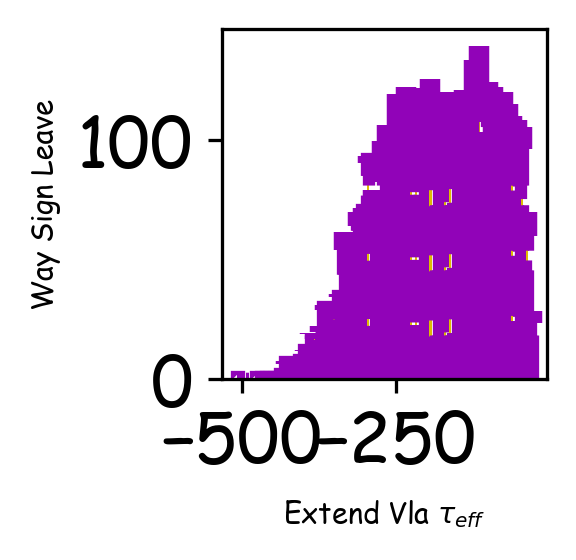

made it here
saved: /Users/jnaiman/Downloads/tmp/JCDL2025/visual_qa_histograms/example_hists_complex/imgs/Picture1.png
 ------ Plot #0 ------ 
Plot type:histogram
Distribution:linear
m * x + b: m & b = -1.2350285109786452 & -73.07572724516172

[ERROR]: overlapping boxes!


SystemExit: 

UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.

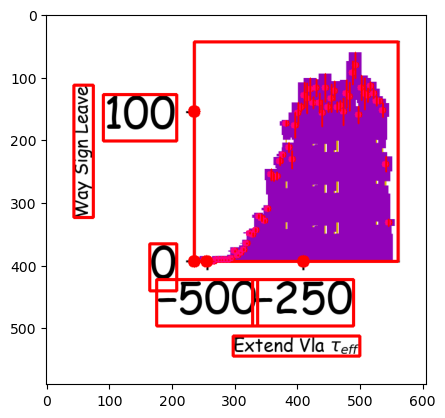

In [239]:
fontsize_min = 8 # minimum to try to shrink titles
aspect_cut = {'min':0.3, 'max':4.0}


success_plot = False # overall plot

# flags for various things
success_titles = False
# redo_gen_fig = True
# redo_gen_plot = True
# redo_gen_titles = True
# redo_gen_axis_labels = True

# keep titles
xlabels_pull = deepcopy(popular_nouns)
ylabels_pull = deepcopy(popular_nouns)
titles_pull = deepcopy(popular_nouns)

grace_ticks = 5 # ignore tick marks that are outside the box by this -- invisible most likely
itriesMax = 100

ifigure = 0
itries = 0
while not success_plot and itries <= itriesMax:
    itries += 1
    #print('at top')
    rng = np.random.default_rng(seed)
    while not success_titles: # ensure we catch any errors with bad fonts
        try:
            #if redo_gen_fig:
            #print('hi')
            fig, axes, plot_inds = make_base_plot(plot_style, color_map, dpi, nrows, ncols, aspect_fig,
                            base=2, verbose=True, tight_layout = tight_layout)
                #redo_gen_fig = False

            #if redo_gen_plot:
            #print('hi2')
            data_from_plot, ax = make_plot(plot_params_out[plot_type], data_for_plot, 
                                    axes[0], plot_type=plot_type, linestyles=linestyles_hist, 
                                    rng=rng)
                #redo_gen_plot = False

            # get title and axis words
            #if redo_gen_titles:
            #print('hi3')
            title, xlabel, ylabel = add_titles_and_labels(axes[0], xlabels_pull, ylabels_pull, titles_pull, 
                                                    title_params, csfont, title_fontsize, 
                                xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
                                inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
                                rng=rng_titles)
            # set "pulls" to save, reset letter as needed
            try:
                xlabels_pull = xlabel.get_text()
            except:
                if type(xlabel) == type([]) or type(xlabel) == type('hi'):
                    xlabels_pull = xlabel
                else:
                    lfkasjl
            try:
                ylabels_pull = ylabel.get_text()
            except:
                if type(ylabel) == type([]) or type(ylabel) == type('hi'):
                    ylabels_pull = ylabel
                else:
                    flasj
            try:
                titles_pull = title.get_text()
            except:
                if type(title) == type([]) or type(title) == type('hi'):
                    titles_pull = title
                else:
                    flasj
            #     redo_gen_titles = False
            # if redo_gen_axis_labels:
            #     _, xlabel, ylabel = add_titles_and_labels(axes[0], xlabels_pull, ylabels_pull, titles_pull, 
            #                                         title_params, csfont, title_fontsize, 
            #                     xlabel_params, ylabel_params, xlabel_fontsize, ylabel_fontsize,
            #                     inlines, xlabel_ticks_fontsize, ylabel_ticks_fontsize,
            #                     rng=rng)   
            #     redo_gen_axis_labels = False    
            #print('hi4')         
            success_titles = True
            plt.draw()
            plt.pause(0.001)
        except Exception as e:
            plt.close('all')
            #print("HERE")
            if 'missing from font' in str(e):
                print('[ERROR]: missing font (' + str(e) + '), will try with new font')
                seed_font = np.random.randint(maxint)
                rng_font = np.random.default_rng(seed_font)
                _, _, _, _, _, _, csfont = get_font_info(fontsizes, font_names, rng=rng_font)
                success_titles = False
            else:
                print('[ERROR]: other error - ', str(e))
                laslfjasl
            continue

    print('made it here')
    plt.set_cmap(color_map) # do again
    fig.tight_layout()
    # collect data
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    # save data
    datas = {}
    # figure datas
    datas['figure'] = {'dpi':dpi, 'base':base, 'aspect ratio': aspect_fig, 
                        'nrows':nrows, 'ncols':ncols, 
                        'plot style':plot_style, 
                        'color map':color_map,
                        'title fontsize':title_fontsize, 
                        'xlabel fontsize':xlabel_fontsize,
                        'ylabel fontsize':ylabel_fontsize, 
                    'plot indexes':plot_inds}
    for iplot,ax in enumerate(axes): ### XYZ, only 1 axis here
        datas['plot' + str(iplot)] = collect_plot_data_axes(ax, fig,
                        height, width,
                        data_from_plot, data_for_plot, 
                        plot_type, title, 
                        xlabel, ylabel,
                        distribution_type, verbose=True)
        

    ########### CHECKS ##########
    # 1. Check for square with weird aspect ratio
    success_aspect = True
    # check for thin/fat squares
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            w = v['square']['xmax']-v['square']['xmin']
            h = v['square']['ymax']-v['square']['ymin']
            if w/h > aspect_cut['max'] or w/h < aspect_cut['min']:
                success_aspect = False

    if not success_aspect:
        # regenerate figure with new aspect ratio
        success_titles = False
        # redo_gen_fig = True
        # redo_gen_plot = True
        continue


    # check for overlaps of x/y axis labels, tickmarks or anything outside of the figbox
    success_axis_labels = True
    success_title_label = True
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            # check if x is out of bounds
            for axislabel in ['xlabel', 'ylabel']:
                if v[axislabel]['xmin'] < 0 or v[axislabel]['xmax'] > width or \
                    v[axislabel]['ymin'] < 0 or v[axislabel]['ymax'] > height:
                    success_axis_labels = False
            # also title
            if 'title' in v:
                if v['title']['xmin'] < 0 or v['title']['xmax'] > width or \
                    v['title']['ymin'] < 0 or v['title']['ymax'] > height:
                    success_title_label = False

        if not success_axis_labels:
            print('[ERROR]: x/y axis off page, making smaller...')
            xlabel_fontsize, ylabel_fontsize, err = get_new_xylabels(xlabel_fontsize, ylabel_fontsize, rng, 
                                                                                fontsize_min = fontsize_min)
            # regenerate x/y titles if fontsize too small
            success_titles = False
            # redo_gen_fig = True
            # redo_gen_plot = True
            if err: # regenerate labels
                #print("HERE")
                xlabels_pull = deepcopy(popular_nouns)
                ylabels_pull = deepcopy(popular_nouns)
                # reset RNG for labels
                seed_titles = np.random.randint(maxint)
                rng_titles = np.random.default_rng(seed_titles)
                #redo_gen_axis_labels = True
                #break # I think...
            else:
                print('   new fontsizes (x,y):', xlabel_fontsize, ylabel_fontsize)

        if not success_axis_labels and err:
            continue


        if not success_title_label:
            print('[ERROR]: title axis off page, making smaller...')
            title_fontsize, err = get_new_title(title_fontsize, rng, 
                                                fontsize_min=fontsize_min)
            # regenerate titles if fontsize too small
            success_titles = False
            # redo_gen_fig = True
            # redo_gen_plot = True
            if err:
                #redo_gen_titles = True
                #print("HERE2")
                titles_pull = deepcopy(popular_nouns)
                # reset RNG for labels
                seed_titles = np.random.randint(maxint)
                rng_titles = np.random.default_rng(seed_titles)
            else:
                print('   new fontsize:', title_fontsize)

            #break # I think...            


    if not success_title_label or not success_axis_labels:
        continue
            

    # now check overlapping boxes
    # first make boxes
    boxes_check = []
    success_boxes = True
    for k,v in datas.items():
        if 'plot' in k: # a plot key
            # square!
            boxes_check.append(([v['square']['xmin'], v['square']['ymin'], 
                                        v['square']['xmax'], v['square']['ymax']], 'square'))
            if 'title' in v:
                boxes_check.append( ([v['title']['xmin'], v['title']['ymin'], 
                                        v['title']['xmax'], v['title']['ymax']], 'title') )
            # xlabel
            boxes_check.append( ([v['xlabel']['xmin'], v['xlabel']['ymin'], 
                                        v['xlabel']['xmax'], v['xlabel']['ymax']], 'xlabel') )
            # ylabel
            boxes_check.append( ([v['ylabel']['xmin'], v['ylabel']['ymin'], 
                                        v['ylabel']['xmax'], v['ylabel']['ymax']],'ylabel')  )
            # x/yticks
            for t in ['x','y']:
                for tick in v[t+'ticks']:
                    # ignore things that are outside square
                    if tick['tx'] < v['square']['xmin']-grace_ticks or tick['tx'] > v['square']['xmax']+grace_ticks or \
                      tick['ty'] < v['square']['ymin']-grace_ticks or tick['ty'] > v['square']['ymax']+grace_ticks:
                        continue
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-tick labels') )
            # x/y offset labels
            for t in ['x','y']:
                if t + '-offset text' in v:
                    tick = v[t + '-offset text']
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-offset text') )

            # if colorbar, add this
            if 'color bar' in v:
                boxes_check.append(([v['color bar']['xmin'], v['color bar']['ymin'], 
                                        v['color bar']['xmax'], v['color bar']['ymax']],'colorbar'))
                # also check for label
                if 'label' in v['color bar']:
                    xmin = v['color bar']['label']['xmin']
                    ymin = v['color bar']['label']['ymin']
                    xmax = v['color bar']['label']['xmax']
                    ymax = v['color bar']['label']['ymax']
                    boxes_check.append(([xmin,ymin,xmax,ymax],'colorbar label'))
                # and offset text
                if 'offset text' in v['color bar']:
                    xmin = v['color bar']['offset text']['xmin']
                    ymin = v['color bar']['offset text']['ymin']
                    xmax = v['color bar']['offset text']['xmax']
                    ymax = v['color bar']['offset text']['ymax']
                    boxes_check.append(([xmin,ymin,xmax,ymax],'colorbar offset text'))
                    
            # colorbar ticks
            if 'color bar ticks' in v:
                for tick in v['color bar ticks']:
                    boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']], 'colorbar tick') )

    # now run and check all boxes -- look for overlap of all boxes
    names_overlap = []
    for ib1,(box1,name1) in enumerate(boxes_check):
        for ib2,(box2,name2) in enumerate(boxes_check):
            if ib1 != ib2: # ib1 < ib2?
                if isRectangleOverlap( box1, box2 ):
                    names_overlap.append( (name1, name2) )
                    success_boxes = False


    # for diagnostics! -- move to after success of fig!
    fig.savefig(fake_figs_dir + 'imgs/Picture' + str(ifigure+1) + '.png', dpi=dpi)#, bbox_inches='tight')
    print('saved:', fake_figs_dir + 'imgs/Picture' + str(ifigure+1) + '.png')

    # check if issue opening plot
    e = ''
    try:
        img = np.array(Image.open(fake_figs_dir + 'imgs/Picture' + str(ifigure+1) + '.png'))
    except Exception as e:
        success_titles = False
        # redo_gen_fig = True
        # redo_gen_plot = True
        if verbose: 
            print('[ERROR]: Issue with opening image!')
            if str(e) != '': print('Full error:', str(e))


    img_diag = np.array(Image.open(fake_figs_dir + 'imgs/Picture' + str(ifigure+1) + '.png').convert('RGB'))
    imgplot = add_annotations(img_diag, img_diag, deepcopy(datas))            

    if not success_boxes: # check who overlaps with who
        print('[ERROR]: overlapping boxes!')
        plt.imshow(imgplot)
        #names_overlap = np.unique(names_overlap)
        import sys; sys.exit()

    success_plot = True # hurray if we've made it this far!
    # if all went well, reset seed
    seed = np.random.randint(maxint)
    #rng = np.random.default_rng(seed)

    print('SUCCESS')
    plt.close(fig)
    #import sys; sys.exit()
    # dump full data
    dumped = json.dumps(datas, cls=NumpyEncoder)
    with open(fake_figs_dir + 'jsons/Picture' + str(ifigure+1) + '_fullData.json', 'w') as f:
        json.dump(dumped, f)

        # HERE -- check for overlapping boxes of:
        # x/y axis labels -- make smaller or pull new ones
        # title -- make smaller or pull new ones
        # square -- might not have to worry about this one? or if flagged, then make smaller the thing (title, etc) ?
        # x/y tick marks -- if x/y tick marks overlap -- try making them smaller, but if continue to overlap, redo whole plot -- redo_gen_fig = True & repull fonts

if success_plot:
    print('DONE MAKING PLOT!')
else:
    print("--- maxed out tries, plot failed ---")

In [234]:
datas['plot0']['xticks']

[{'data': '−750',
  'xmin': 23.955040265112757,
  'ymin': 91.63888888888886,
  'xmax': 184.95504026511276,
  'ymax': 166.13888888888886,
  'tx': 104.45504026511276,
  'ty': 194.8194444444444},
 {'data': '−500',
  'xmin': 176.82438510490869,
  'ymin': 91.63888888888886,
  'xmax': 337.8243851049087,
  'ymax': 166.13888888888886,
  'tx': 257.3243851049087,
  'ty': 194.8194444444444},
 {'data': '−250',
  'xmin': 329.6937299447046,
  'ymin': 91.63888888888886,
  'xmax': 490.6937299447046,
  'ymax': 166.13888888888886,
  'tx': 410.1937299447046,
  'ty': 194.8194444444444},
 {'data': '0',
  'xmin': 541.8130747845006,
  'ymin': 91.63888888888886,
  'xmax': 584.3130747845006,
  'ymax': 166.13888888888886,
  'tx': 563.0630747845006,
  'ty': 194.8194444444444}]

In [236]:
for k,v in datas.items():
    if 'plot' in k: # a plot key
        # x/yticks
        for t in ['x','y']:
            for tick in v[t+'ticks']:
                # ignore things that are outside square
                if tick['tx'] < v['square']['xmin']-grace_ticks or tick['tx'] > v['square']['xmax']+grace_ticks or \
                  tick['ty'] < v['square']['ymin']-grace_ticks or tick['ty'] > v['square']['ymax']+grace_ticks:
                    continue
                boxes_check.append( ([tick['xmin'],tick['ymin'],tick['xmax'],tick['ymax']],t+'-tick labels') )

In [237]:
boxes_check

[([236.50360236725302,
   194.8194444444444,
   561.7856779050541,
   541.8453436824858],
  'square'),
 ([399.4667223009111, 566.4286770158192, 399.4667223009111, 566.4286770158192],
  'title'),
 ([346.5917223009111, 44.24999999999997, 452.3417223009111, 75.24999999999997],
  'xlabel'),
 ([44.249999999999964,
   263.83239406346513,
   75.24999999999997,
   472.83239406346513],
  'ylabel'),
 ([176.82438510490869,
   91.63888888888886,
   337.8243851049087,
   166.13888888888886],
  'x-tick labels'),
 ([329.6937299447046,
   91.63888888888886,
   490.6937299447046,
   166.13888888888886],
  'x-tick labels'),
 ([541.8130747845006,
   91.63888888888886,
   584.3130747845006,
   166.13888888888886],
  'x-tick labels'),
 ([165.51388888888886,
   147.8194444444444,
   208.01388888888886,
   222.3194444444444],
  'y-tick labels'),
 ([91.63888888888886,
   471.26687879540714,
   208.01388888888886,
   545.7668787954071],
  'y-tick labels')]

In [238]:
v['square']

{'xmin': 236.50360236725302,
 'ymin': 194.8194444444444,
 'xmax': 561.7856779050541,
 'ymax': 541.8453436824858}